Consider that you have a online art gallery with thousands of paintings. How would you search through it? You can search for artists or painting titles but what if you want to search for a painting by description?
Descriptions may not be available for all paintings. You can get descriptions written manually for each painting but it would be an huge amount of work and would slow down the digitization process. What if we could search through images of paintings without manually labelling them?
For example, if you search for a painting of sea waves in a Japenese style, you would expect to see something like this.

<img src="https://www.artic.edu/iiif/2/b3974542-b9b4-7568-fc4b-966738f61d78/full/1686,/0/default.jpg">

We are going to train a image encoder model which can be used to index the images, and we can train a text encoder model which can encode our search query. We can then find our image by finding the nearest image vector to our text vector.

For this task, we are going to finetune CLIP model which was trained on a large training dataset and hence has good zero shot preformance. We will take pretrained model as a baseline and see if we can improve its performance on our task by finetuning.

We are going to use dataset from [Art Institute of Chicago](https://www.artic.edu/) to finetune our model. It has images of artworks and information such as title, artist, alt_text and description. We are going to use descriptions as they are more suitable for our problem.

Let's import the required libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import multiprocessing

In [3]:
import tensorflow as tf

In [4]:
from sklearn.model_selection import train_test_split

In [ ]:
# Installing dependencies
!pip install transformers

!pip install git+https://github.com/abhisharsinha/similarity@gsoc

In [6]:
from tensorflow_similarity.losses import MultiNegativesRankLoss

In [7]:
from transformers import TFCLIPTextModel, TFCLIPVisionModel, CLIPTokenizer, TFCLIPModel

In [8]:
from tensorflow.data.experimental import AUTOTUNE

In [10]:
n_cpu = multiprocessing.cpu_count()

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 64
COLOR_CHANNELS = 3
N_TOKENS = 77

Doownloading the dataset

In [12]:
!wget https://huggingface.co/datasets/abhishars/artic-dataset/resolve/main/artworks.csv

In [13]:
!wget https://storage.googleapis.com/mys-released-models/gsoc/artic-dataset.zip

In [14]:
!unzip artic-dataset.zip

We want to get embeddings of images and texts such that the distance between image and it's description is lesser than the image and description of any other image.
First, we need a way to get text and image embeddings.

Getting weights of projection layers after vision and text encoder models of CLIP

In [15]:
tf.keras.backend.clear_session()
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
vision_weights = tf.Variable(model.weights[-2])
text_weights = tf.Variable(model.weights[-1])
del model
tf.keras.backend.clear_session()

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


We'll use CLIPTextModel and CLIPVisionMOdel to embed text and images respectively.

Loading pretrained CLIP text encoder model and the corresponding tokenizer

In [ ]:
CLIP_text_model = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32", )
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
CLIP_vision_model = TFCLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32",  )

If you have GPU restrictions you can set the base models as non-trainable and only train the projector layer for a faster optimization.

In [18]:
# CLIP_vision_model.trainable = False
CLIP_vision_model.summary()

Model: "tfclip_vision_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clip (TFCLIPVisionMainLayer  multiple                 87456000  
 )                                                               
                                                                 
Total params: 87,456,000
Trainable params: 87,456,000
Non-trainable params: 0
_________________________________________________________________


In [19]:
# CLIP_text_model.trainable = False
CLIP_text_model.summary()

Model: "tfclip_text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clip (TFCLIPTextMainLayer)  multiple                  63165952  
                                                                 
Total params: 63,165,952
Trainable params: 63,165,952
Non-trainable params: 0
_________________________________________________________________


Since the embedding size of CLIPVisionModel and CLIPTextModel are different, we need projection layers at the top of both these models to make embedding of same dimension.

In [ ]:
def get_image_model(n_dims=512):
    x = tf.keras.layers.Input((COLOR_CHANNELS, IMG_SIZE, IMG_SIZE),
                              name="image")
    vision_outputs = CLIP_vision_model(x)
    vision_last_hidden_state = vision_outputs.last_hidden_state
    vision_pooled_output = vision_outputs.pooler_output  # pooled CLS states
    vision_init = tf.constant_initializer(vision_weights.numpy())
    img_embed = tf.keras.layers.Dense(n_dims,
                                      name="image_embedding",
                                      kernel_initializer=vision_init
                                      )(vision_pooled_output)
    img_model = tf.keras.models.Model(inputs=x,
                                      outputs=img_embed,
                                      name="image_model")

    return img_model

In [ ]:
def get_text_model(n_dims=512):
    x1 = tf.keras.layers.Input((N_TOKENS),
                               dtype=tf.int32,
                               name="input_ids")
    x2 = tf.keras.layers.Input((N_TOKENS),
                               dtype=tf.int32,
                               name="attention_mask")
    text_outputs = CLIP_text_model(input_ids=x1, attention_mask=x2)
    text_last_hidden_state = text_outputs.last_hidden_state
    text_pooled_output = text_outputs.pooler_output
    text_init = tf.constant_initializer(text_weights.numpy())
    text_embed = tf.keras.layers.Dense(n_dims,
                                       name="text_embedding",
                                       kernel_initializer=text_init
                                       )(text_pooled_output)
    text_model = tf.keras.models.Model(inputs=[x1, x2],
                                       outputs=text_embed,
                                       name="text_model")

    return text_model

In [ ]:
tf.keras.backend.clear_session()
img_model = get_image_model()
text_model = get_text_model()

In [ ]:
img_model.summary()

Model: "image_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 3, 224, 224)]     0         
                                                                 
 tfclip_vision_model (TFCLIP  TFBaseModelOutputWithPoo  87456000 
 VisionModel)                ling(last_hidden_state=(            
                             None, 50, 768),                     
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 image_embedding (Dense)     (None, 512)               393728    
                                                                 
Total params: 87,849,728
Trainable params: 87,849,728
N

In [ ]:
text_model.summary()

Model: "text_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 77)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 77)]         0           []                               
                                                                                                  
 tfclip_text_model (TFCLIPTextM  TFBaseModelOutputWi  63165952   ['input_ids[0][0]',              
 odel)                          thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 77,                                               
                                 512),                                                   

Now let's load our dataset

In [20]:
art_df = pd.read_csv("artworks.csv")
art_df.head(10)

,art_id,image_id,alt_text,description,full_description,artist,title
0,795,2fa88251-065a-8c94-d918-63bfd5c866c0,"Rectangular, mostly brown textile made up of m...",NaN,NaN,NaN,Kesa
1,1936,1733f6b2-2cac-e8fe-4ecd-c0587da78b30,"A work made of silk, plain compound cloth.",NaN,NaN,NaN,Fragment
2,4425,0da94f5f-4be8-a3d0-00c0-53d48ad4a2cf,A work made of color woodblock print; chuban.,NaN,NaN,Utagawa Hiroshige,"Kyoto: The Imperial Palace (Kyo, Dairi), from ..."
3,5431,121a5968-7d19-5879-8974-b6a6bdaa5d1f,"A work made of black crayon, with touches of c...",NaN,NaN,László Moholy-Nagy,Seated Woman II
4,8101,c24feb4e-d7f5-791e-58ee-5db1a40d0a0d,"A work made of cotton, plain weave; drawnwork ...",This apron mimics lace in its play of transluc...,This apron mimics lace in its play of transluc...,NaN,Apron
5,10393,357c901c-c54f-079c-0c29-d3be0a021ed4,A work made of porcelain painted in underglaze...,NaN,NaN,NaN,"Deep Dish with Peony, Pine Branches, Plum Blos..."
6,10924,179ae0da-8834-7c92-3b25-377a08dac9e4,A work made of blown glass.,NaN,NaN,Artist unknown,Cream Pitcher
7,11460,b84f047e-f871-48c5-6bbf-618731650105,A work made of engraving in black on ivory lai...,"The ', <a href='https://www.artic.edu/artists/...","The ', <a href='https://www.artic.edu/artists/...",Master of the E-Series Tarocchi,"Philosophy, plate 28 from Arts and Sciences"
8,11785,04ed0f69-131f-bf49-b791-22e9cb692adb,A work made of etching and drypoint in black o...,NaN,NaN,Donald Shaw MacLaughlan,A Lion
9,12707,22306679-f60a-1c18-4a7f-08720d17aab2,"A work made of cotton, mixed lace: bobbin lace...",NaN,NaN,NaN,Stole


In [21]:
art_df.drop_duplicates(subset=["description"], inplace=True)

In [22]:
art_df.dropna(subset=["description"], inplace=True)

In [23]:
art_df.count()

art_id              7005
image_id            7005
alt_text            7005
description         7005
full_description    7005
artist              6467
title               7005
dtype: int64

In [24]:
all_images = set(list(os.listdir("artic-dataset/")))
len(all_images)

37649

In [25]:
imgs_list = []
text_list = []
for i in tqdm(art_df.iterrows()):
    if i[1]["image_id"]+".jpg" in all_images:
        imgs_list.append("artic-dataset/{}.jpg".format(i[1]["image_id"]))
        # tokenizer cannot take tf str so pretokenizing
        text_list.append(i[1]["description"])

7005it [00:00, 8217.53it/s]


In [26]:
train_images, val_images, train_texts, val_texts = train_test_split(imgs_list, text_list, test_size=0.2, random_state=17)

train_tokens = tokenizer(train_texts,
                    padding="max_length",
                    return_tensors="tf",
                    truncation=True,
                    )

val_tokens = tokenizer(val_texts,
                    padding="max_length",
                    return_tensors="tf",
                    truncation=True,
                    )

In [27]:
def get_img_emb(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method="nearest")
    image = tf.transpose(image, [2, 0, 1]) # Channels first
    return image


def data_mapper(img, input_ids, attention_mask):
    return get_img_emb(img), tf.squeeze(input_ids), tf.squeeze(attention_mask)

In [29]:
train_ds = tf.data.Dataset.from_tensor_slices(
                            (train_images,
                             train_tokens["input_ids"],
                             train_tokens["attention_mask"])
                            )
train_ds = train_ds.map(data_mapper, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
for i in train_ds.take(1):
    for j in i:
        print(j.shape)

val_ds = tf.data.Dataset.from_tensor_slices((val_images,
                             val_tokens["input_ids"],
                             val_tokens["attention_mask"])
                            )
val_ds = val_ds.map(data_mapper, num_parallel_calls=n_cpu).batch(BATCH_SIZE).cache()
for i in val_ds.take(1):
    for j in i:
        print(j.shape)

(64, 3, 224, 224)
(64, 77)
(64, 77)
(64, 3, 224, 224)
(64, 77)
(64, 77)


We have a dataset which have pairs of image and text. We only have positive examples here and in such a case multiple negatives ranking loss is a suitable choice. This considers every other pair other than ($x_i$, $y_i$) as negative pairs.

In [35]:
loss_fn = MultiNegativesRankLoss()

We'll use R@k metric for evaluation. This is a common metric used in evaluation of ranking. It is the average of recall by taking top k predictions.

In [36]:
def recall_at_k(sim_matrix, k=1):
    """ 
        It is the mean of ratio of correctly retrieved documents
        to the number of relevant documents.
        This implementation is specific to
        data having unique label for each key
    """
    
    sorted_mat = np.argsort(sim_matrix, axis=1)[:,-k:]
    
    # Each key has unique label
    true_labels = np.arange(sorted_mat.shape[0]).reshape(-1,1)
    true_labels = np.repeat(true_labels, k, axis=1)
    sorted_mat = sorted_mat - true_labels
    # the position in row corresponding to true positive
    # will be zero
    tps = np.any(sorted_mat == 0, axis=1)
    return tps.mean()

Let's measure the baseline performance.

In [37]:
val_loss = 0
base_image_embeddings = []
base_text_embeddings = []
for image_batch, input_ids_batch, attention_mask_batch in tqdm(val_ds):
    image_embedding = img_model(image_batch, training=False)
    text_embedding = text_model([input_ids_batch, attention_mask_batch], training=False)

    image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
    text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

    base_image_embeddings.append(image_embedding.numpy())
    base_text_embeddings.append(text_embedding.numpy())
    
    # Compute the loss value for this minibatch.
    loss_value = loss_fn(text_embedding, image_embedding)
    val_loss += float(loss_value)
print(val_loss/len(val_ds))
base_image_embeddings = np.concatenate(base_image_embeddings)
base_text_embeddings = np.concatenate(base_text_embeddings)

100%|██████████| 22/22 [00:09<00:00,  2.29it/s]

2.6188373348929663


In [38]:
base_sim_mat = np.matmul(base_text_embeddings, base_image_embeddings.T)

In [39]:
for k in range(1, 6):
    print("R@{}: {}".format(k, recall_at_k(base_sim_mat, k)))

R@1: 0.1841541755888651
R@2: 0.2676659528907923
R@3: 0.31977159172019987
R@4: 0.3576017130620985
R@5: 0.3811563169164882


Now let's train the models.
Since we have two models that need to be trained together, we'll use custom training loop similar to [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#end-to-end_example_a_gan_training_loop_from_scratch).

Let's define the train_step where model's weights are updated based on a batch and then start the training loop in which each epochs calls the train_step for every batch.

In [40]:
@tf.function
def train_step(image_batch, text_batch):
    with tf.GradientTape() as img_tape, tf.GradientTape() as text_tape:
            
        image_embedding = img_model(image_batch, training=True)
        text_embedding = text_model(text_batch, training=True)

        image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
        text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(text_embedding, image_embedding)

    img_grads = img_tape.gradient(loss_value, img_model.trainable_weights)
    text_grads = text_tape.gradient(loss_value, text_model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    img_optimizer.apply_gradients(zip(img_grads, img_model.trainable_weights))
    text_optimizer.apply_gradients(zip(text_grads, text_model.trainable_weights))

    return loss_value

In [41]:
epochs = 5
img_optimizer = tf.keras.optimizers.Adam(1e-5)
text_optimizer = tf.keras.optimizers.Adam(1e-5)
train_step_losses = []
train_epoch_losses = []

for epoch in range(epochs):
    print("\nEpoch %d" % (epoch+1,))
    epoch_loss = 0

    # Iterate over the batches of the dataset.
    for step, (image_batch, input_ids_batch, attention_mask_batch) in enumerate(train_ds):
        loss_value = train_step(image_batch, [input_ids_batch, attention_mask_batch])
        epoch_loss += float(loss_value)
        train_step_losses.append(float(loss_value)/image_batch.shape[0])
        # Log every batch
        if step % 100 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step+1, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * BATCH_SIZE))
    print("Epoch loss:", epoch_loss/len(train_ds))
    train_epoch_losses.append(epoch_loss/len(train_ds))


Epoch 1
Training loss (for one batch) at step 1: 2.6298
Seen so far: 64 samples
Epoch loss: 1.248113751411438

Epoch 2
Training loss (for one batch) at step 1: 0.5429
Seen so far: 64 samples
Epoch loss: 0.3632849793965844

Epoch 3
Training loss (for one batch) at step 1: 0.1357
Seen so far: 64 samples
Epoch loss: 0.1251609335357154

Epoch 4
Training loss (for one batch) at step 1: 0.0729
Seen so far: 64 samples
Epoch loss: 0.06818865270311521

Epoch 5
Training loss (for one batch) at step 1: 0.0656
Seen so far: 64 samples
Epoch loss: 0.03815177821723575


Text(0, 0.5, 'Loss')

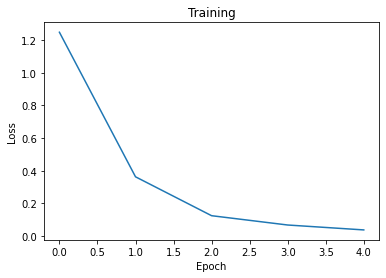

In [42]:
plt.plot(train_epoch_losses)
plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

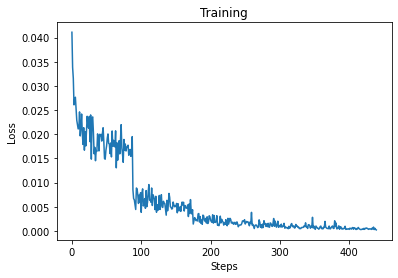

In [43]:
plt.plot(train_step_losses)
plt.title("Training")
plt.xlabel("Steps")
plt.ylabel("Loss")

Now let's check the performance on validation data after finetuning.

In [44]:
val_loss = 0
image_embeddings = []
text_embeddings = []
for image_batch, input_ids_batch, attention_mask_batch in tqdm(val_ds):
    image_embedding = img_model(image_batch, training=False)
    text_embedding = text_model([input_ids_batch, attention_mask_batch], training=False)

    image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
    text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

    image_embeddings.append(image_embedding.numpy())
    text_embeddings.append(text_embedding.numpy())
    
    # Compute the loss value for this minibatch.
    loss_value = loss_fn(text_embedding, image_embedding)
    val_loss += float(loss_value)
print(val_loss/len(val_ds))
image_embeddings = np.concatenate(image_embeddings)
text_embeddings = np.concatenate(text_embeddings)

100%|██████████| 22/22 [00:10<00:00,  2.15it/s]

0.992127467285503


In [45]:
finetuned_sim = np.matmul(text_embeddings, image_embeddings.T)

In [47]:
for k in range(1,6):
    print("R@{} : {}".format(k, recall_at_k(finetuned_sim, k)))

R@1 : 0.2955032119914347
R@2 : 0.39543183440399715
R@3 : 0.4732334047109208
R@4 : 0.5339043540328337
R@5 : 0.5724482512491078


We can see that thre is a significant imrovement in recall metric after only 5 epochs of training.
Now, we can use these modes for painting retrival based on text query.

The models can be saved in the same way as any other keras model.

In [ ]:
img_model.save("image_model.h5")
text_model.save("text_model.h5")

However when loading these saved models, the CLIP vision and text models must be provided in custom objects.

In [ ]:
img_model = tf.keras.models.load_model("image_model.h5", custom_objects={"TFCLIPVisionModel":TFCLIPVisionModel})
text_model = tf.keras.models.load_model("text_model.h5", custom_objects={"TFCLIPTextModel":TFCLIPTextModel})